In [60]:
import math
import random
import ssl
import urllib.request
import evaluator
import os
import torch
import torchvision.transforms as transforms
import importlib
import plot_utility
import deviceUtility
import certifi
import torch.nn as nn
import torch.nn.functional as functional

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm import tqdm
from tqdm.auto import tqdm


In [61]:
# Fix SSL certificate issue
ssl_context = ssl.create_default_context(cafile=certifi.where())
urllib.request.install_opener(urllib.request.build_opener(urllib.request.HTTPSHandler(context=ssl_context)))

In [62]:
gpu = deviceUtility.get_best_available_device()

________________________

Device manager:
Running on device: mps
________________________


### Hyperparameters

In [63]:
TIME_STEP = 1000
EPOCH_NUM = 20
LEARNING_RATE = 1e-4

BETA_START = 1e-4
BETA_END = 0.02

BATCH_SIZE = 32

GUIDANCE_PROBABILITY = 0.5
GUIDANCE_WEIGHT = 0.2

SCHEDULER = "linear" #either 'linear' or 'cosine'


### Precalculations

In [64]:
def cosine_beta_scheduler(steps, s=0.008):
    """
    cosine scheduler as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = steps + 1
    x = torch.linspace(0, steps, steps, device=gpu)
    alphas_cumulative_prod = torch.cos(((x / steps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumulative_prod = alphas_cumulative_prod / alphas_cumulative_prod[0]
    beta_values = 1 - (alphas_cumulative_prod[1:] / alphas_cumulative_prod[:-1])
    
    beta_min, beta_max = 0.0001, 0.9999
    return torch.clip(beta_values, beta_min, beta_max)

def get_betas(scheduler_name):
    """Returns a beta schedule based on the name of the scheduler, either 'linear' or 'cosine'"""
    if scheduler_name == "linear":
        return torch.linspace(BETA_START, BETA_END, TIME_STEP, device=gpu)
    elif scheduler_name == "cosine":
        return cosine_beta_scheduler(TIME_STEP)
    else:
        raise NotImplementedError()
        

In [65]:
betas = get_betas(SCHEDULER) 
alphas = 1. - betas
alphas_cum_prod = torch.cumprod(alphas, 0)
alphas_cum_prod_prev = functional.pad(alphas_cum_prod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cum_prod = torch.sqrt(alphas_cum_prod)
sqrt_one_minus_alphas_cum_prod = torch.sqrt(1. - alphas_cum_prod)
posterior_variance = betas * (1. - alphas_cum_prod_prev) / (1. - alphas_cum_prod)

### Helper functions

In [66]:
def extract(equation, timestep, x_shape):
    """
    Extracts the values of the equation for the given timestep for every image in the batch.
    """
    size = timestep.shape[0]
    out = equation.gather(-1, timestep.to(gpu))
    return out.reshape(size, *((1,) * (len(x_shape) - 1))).to(timestep.device)


def q_sample(image_batch, timestep, noise=None):
    """
    Forward pass of the diffusion model.
    Adds noise to an image at time t.
    If noise is not provided, it is sampled from a standard normal distribution.
    """
    if noise is None:
        noise = torch.randn_like(image_batch)

    # Extract the values for every image in the batch for the given timestep
    sqrt_alphas_cum_prod_t = extract(sqrt_alphas_cum_prod, timestep, image_batch.shape)
    sqrt_one_minus_alphas_cum_prod_t = extract(sqrt_one_minus_alphas_cum_prod, timestep, image_batch.shape)

    return sqrt_alphas_cum_prod_t * image_batch + sqrt_one_minus_alphas_cum_prod_t * noise


@torch.no_grad()
def p_sample(model, x, t, t_index, condition):
    """
    Reverse pass of the diffusion model.
    Given an image at time t, it predicts the image at time t-1.
    """
    condition = condition.to(gpu)
    betas_t = extract(betas, t, x.shape)

    sqrt_one_minus_alphas_cum_prod_t = extract(
        sqrt_one_minus_alphas_cum_prod, t, x.shape
    )

    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    model_mean_unconditional = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_cum_prod_t)

    model_mean_conditional = sqrt_recip_alphas_t * (
            x - betas_t * model(x, t, condition) / sqrt_one_minus_alphas_cum_prod_t)
    model_mean_guided = (1 + GUIDANCE_WEIGHT) * model_mean_conditional - GUIDANCE_WEIGHT * model_mean_unconditional

    if t_index == 0:
        return model_mean_guided
    else:
        # Helps determine the amount of noise to remove from the image.
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean_guided + torch.sqrt(posterior_variance_t) * noise


@torch.no_grad()
def p_sample_loop(model,*, shape, conditionals, disable_tqdm = False):
    device = gpu
    b = shape[0]
    conditionals.to(gpu)
    img = torch.randn(shape, device=device)  # Random noised image

    for i in tqdm(reversed(range(0, TIME_STEP)), desc='Sampling loop time step.', total=TIME_STEP, disable=disable_tqdm):
        img = p_sample(model=model, x=img, t=torch.full((b,), i, device=device, dtype=torch.long), t_index=i,
                       condition=conditionals)
    return img


def p_losses(denoise_model, x_start, timestep, conditionals):

    noise = torch.randn_like(x_start)

    # Input image with the random noise and the timestep
    x_noisy = q_sample(x_start, timestep, noise)

    # Feed the noisy image to the denoise model to predict the noise
    predicted_noise = denoise_model(x_noisy, timestep, conditionals)

    model_loss = functional.l1_loss(noise, predicted_noise)
    #model_loss = functional.mse_loss(noise, predicted_noise)
    return model_loss


### Sinusoidal Positional Embedding
As parameter of neural network are 
shared across time one should employ 
a sinusoidal embedding to encode the position of the input. 
Makes the neural network know which timestep it is at.

In [67]:
class SinusoidalPositionalEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super(SinusoidalPositionalEmbedding, self).__init__()
        self.embedding_dim = embedding_dim

    def forward(self, t):
        # Create a sinusoidal embedding for each position in time
        half_dim = self.embedding_dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=gpu) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        return emb.to(gpu)

### Convolutional Layer
Classes which define the building blocks of the UNet architecture.
Consists of double convolutional layers with ReLU activation functions.
Also includes a time embedding layer which is added to the output of the first convolutional layer.

In [68]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super(Block, self).__init__()

        self.time_mlp = nn.Sequential(
            SinusoidalPositionalEmbedding(time_emb_dim),
            nn.Linear(time_emb_dim, out_channels),
            nn.ReLU(inplace=True)
        )

        self.condition_emb = nn.Sequential(
            nn.Linear(num_classes, out_channels),
            nn.ReLU(inplace=True)
        )

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, t, c=None):
        # First convolution
        h = self.relu(self.conv1(x))

        # Compute time embedding and reshape to match spatial dimensions
        time_emb = self.time_mlp(t)
        time_emb = time_emb[(...,) + (None,) * 2]  # Shape (batch, channels, 1, 1)

        # Add time embedding.
        h = h + time_emb

        if isinstance(c, torch.Tensor):
            class_embedding = self.condition_emb(c).to(gpu)
            class_embedding = class_embedding[(...,) + (None,) * 2]  # Shape (batch, channels, 1, 1)
            h = h + class_embedding

        # Second convolution.
        h = self.relu(self.conv2(h))
        return h

### U-net
The UNet architecture for approximating the means of the posterior distribution.
The architecture consists of a contracting path, a bottleneck, and an expanding path.

In [69]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.time_emb_dim = 32
        self.max_pool = nn.MaxPool2d(2, 2)

        # Contracting path.
        self.encoder1 = Block(1, 64, self.time_emb_dim)
        self.encoder2 = Block(64, 128, self.time_emb_dim)

        # Bottleneck: The crossing between contracting and expanding.
        self.bottleneck = Block(128, 256, self.time_emb_dim)

        # Expanding path.
        self.up_convolution_1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_convolution_2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.decoder1 = Block(256, 128, self.time_emb_dim)
        self.decoder2 = Block(128, 64, self.time_emb_dim)

        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x, t, c=None):
        # Contracting path.
        enc1_out = self.encoder1(x, t, c)
        pool_enc1_out = self.max_pool(enc1_out)

        enc2_out = self.encoder2(pool_enc1_out, t, c)
        pool_enc2_out = self.max_pool(enc2_out)

        # Bottleneck
        bottle_out = self.bottleneck(pool_enc2_out, t, c)

        # Expanding path.
        up_conv_1_out = self.up_convolution_1(bottle_out)
        crop_up_conv_1_out = crop_tensor(enc2_out, up_conv_1_out)
        dec1_out = self.decoder1(torch.cat([up_conv_1_out, crop_up_conv_1_out], dim=1), t, c)

        up_conv_2_out = self.up_convolution_2(dec1_out)
        crop_up_conv_2_out = crop_tensor(enc1_out, up_conv_2_out)
        dec2_out = self.decoder2(torch.cat([up_conv_2_out, crop_up_conv_2_out], dim=1), t, c)

        output = self.output_layer(dec2_out)

        return output

def crop_tensor(tensor, target_tensor):
    """Make the tensor the same size as the target tensor by cropping."""
    target_size = target_tensor.size()[2:]
    tensor_size = tensor.size()[2:]
    delta_h = (tensor_size[0] - target_size[0]) // 2
    delta_w = (tensor_size[1] - target_size[1]) // 2
    return tensor[:, :, delta_h:tensor_size[0] - delta_h,
           delta_w:tensor_size[1] - delta_w]

### Load data

In [70]:
image_size = 28 # Length and width of the images
channels = 1  # Grey scale
num_classes = 10 # possible classes in the mnist dataset (0-9)
mnist_transformation = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x * 2) - 1),  # Normalize to [-1, 1]
    ]
)

mnist = MNIST(root='.', train=True, download=True, transform=mnist_transformation)

dataloader = DataLoader(mnist, batch_size=BATCH_SIZE, shuffle=True, )

### Training model


In [71]:
# Train model
diffusion_model = UNet().to(gpu)
optimizer = torch.optim.Adam(diffusion_model.parameters(), lr=LEARNING_RATE)

with tqdm(range(0, EPOCH_NUM), desc="Epochs", total=EPOCH_NUM) as epoch_progress:
    for epoch in epoch_progress:
        for step, (batch, class_values) in enumerate(dataloader):  # Iterate over every batch in the dataloader

            # Convert the labels to one-hot encoding half of the time. 
            if random.random() < GUIDANCE_PROBABILITY:
                batch_conditionals = nn.functional.one_hot(class_values, num_classes=num_classes).float()
            else:
                batch_conditionals = torch.zeros_like(nn.functional.one_hot(class_values, num_classes=num_classes).float())
            optimizer.zero_grad()

            # Get the batch size and move the batch to the device
            batch_size = batch.shape[0]
            batch = batch.to(gpu)

            # Algorithm 1 line 3: sample t uniformly for every example in the batch
            t_sample = torch.randint(0, TIME_STEP, (batch_size,), device=gpu).long()
            batch_conditionals = batch_conditionals.to(gpu)
            loss = p_losses(diffusion_model, batch, t_sample, conditionals=batch_conditionals)

            # If the step is a multiple of 100, print the loss
            if step % 100 == 0:
                epoch_progress.set_postfix(loss=loss.item())

            # Algorithm 1 line 5: backpropagate the loss
            loss.backward()

            # Algorithm 1 line 6: update the weights
            optimizer.step()

Epochs: 100%|██████████| 20/20 [20:10<00:00, 60.51s/it, loss=0.0189]


### Helper functions for generating and images

In [72]:
def get_sequential_guidance():
    """Creates a BATCH_SIZE long tensor with sequential classes"""
    return torch.tensor([i % num_classes for i in range(BATCH_SIZE)])

def get_random_guidance():
    """Creates a BATCH_SIZE long tensor with random ints between 0 (inclusive) and num_classes (exclusive)"""
    return torch.randint(0, num_classes, size=(BATCH_SIZE,))

def get_all_same_guidance(numberClass):
    """Creates a BATCH_SIZE long tensor where all entries are of class 'numberClass'"""
    return torch.ones(BATCH_SIZE, dtype=torch.long) * int(numberClass)

def save_tensor_as_image(tensor, path, start_idx=0):
    """Saves an image tensor as a PIL image"""
    tensor = torch.clamp(tensor, 0, 1)
    
    transform = transforms.ToPILImage()
    for i, img_tensor in enumerate(tensor):
        img = transform(img_tensor)
        img.save(os.path.join(path, f"sample{start_idx + i}.png"))

def generate_images(total_images=10000, fid_batch_size=1000):
    """Generates a 'total_images' images in batches of 'fid_batch_size'"""
    path = "./generated_images"
    os.makedirs(path, exist_ok=True)

    # Generate images in batches
    for batch_idx in tqdm(range(0, total_images, fid_batch_size)):
        class_labels = torch.tensor([i % 10 for i in range(fid_batch_size)])
        class_labels = nn.functional.one_hot(class_labels, num_classes=10).float()
        class_labels = class_labels.to(gpu)
            
        # Generate images
        image_batch = p_sample_loop(
            diffusion_model,
            shape=(batch_size, channels, image_size, image_size),
            conditionals=class_labels
        )

        # Save images with continuous numbering
        save_tensor_as_image(image_batch, path, start_idx=batch_idx)

        torch.cuda.empty_cache()
    

# Model evaluation

### FID (Frechét inception distance)

In [73]:
calculate_fid = False

if calculate_fid:
    generate_images(total_images=10000, fid_batch_size=1000)

### Inception score

Generally, to get optimal scores, the model should create images that looks like the training distribution.
Since our model is guided, we can also try to force it to create an even amount of images of each class.

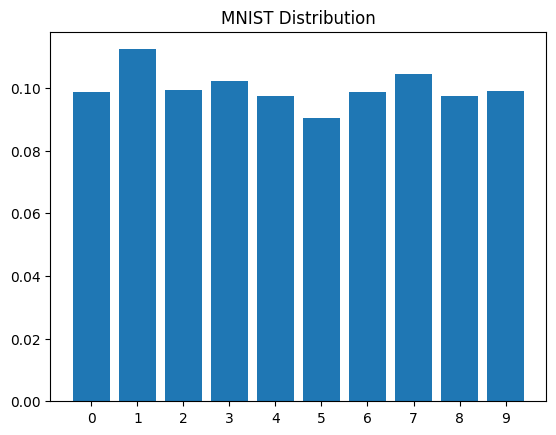

In [74]:
desired_distribution = plot_utility.get_distribution(mnist, show_plot=True)

#### To evaluate, a model pretrained on MNIST images is used, making it a better classifier than inception-v3 for this specific dataset. 
(Note that inception scores are not directly comparable to papers that use inception-v3 even though the mathematical formulas are identical)

In [75]:
importlib.reload(evaluator)
evaluator_model = evaluator.get_MNIST_evaluator(device=gpu)

Sampling loop time step.: 100%|██████████| 1000/1000 [00:16<00:00, 60.07it/s]


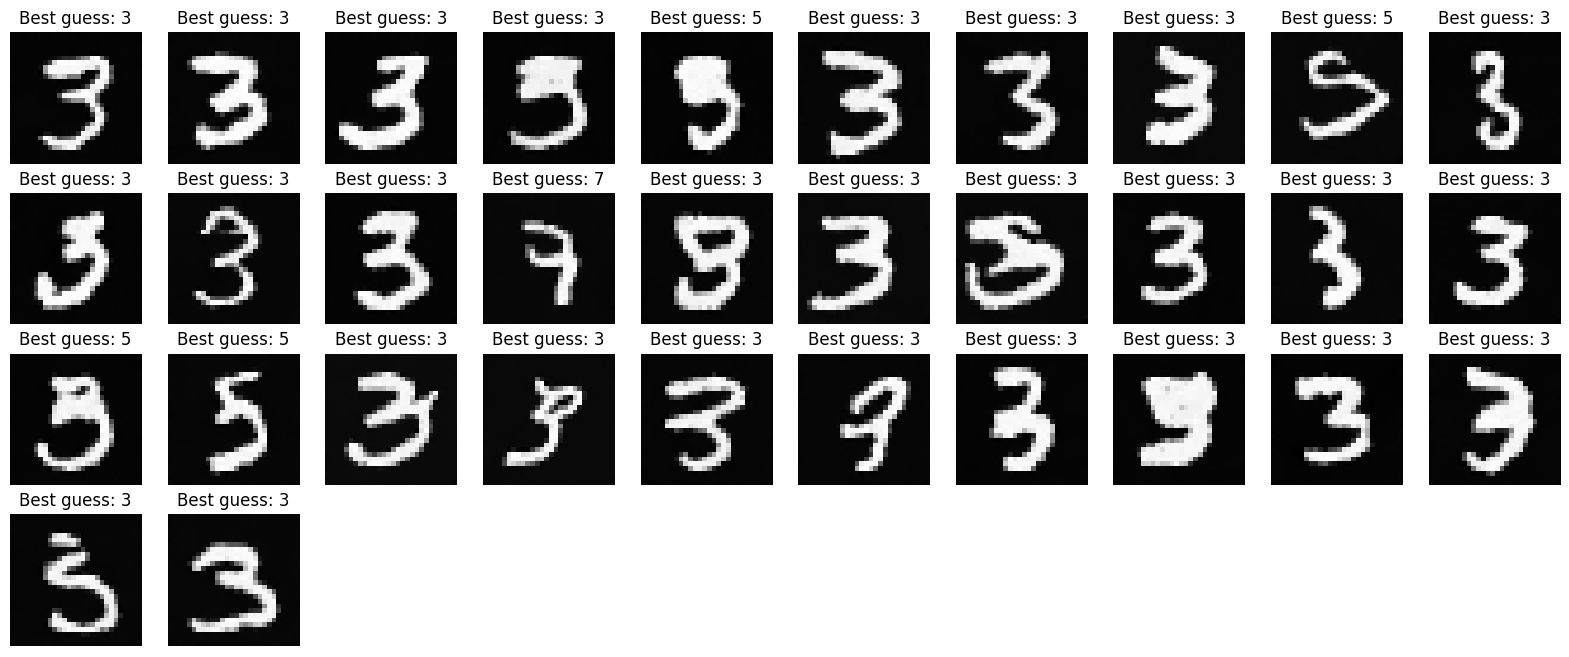

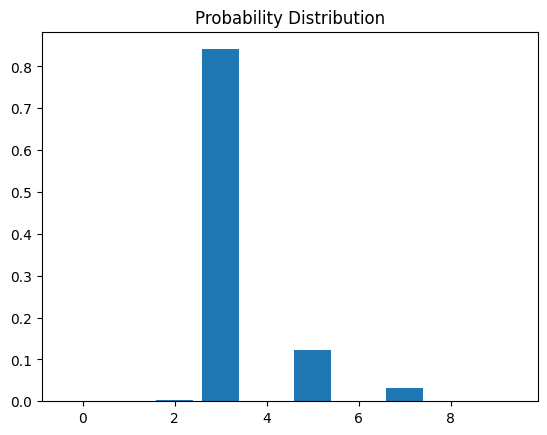

tensor([[8.1993e-09, 2.3979e-04, 4.1807e-03, 8.4078e-01, 2.3498e-10, 1.2341e-01,
         2.3485e-14, 3.1375e-02, 6.9176e-06, 9.3811e-06]], device='mps:0')


In [82]:
def show_example(num):
    numbers = get_all_same_guidance(num)
    numbers = nn.functional.one_hot(numbers, num_classes=num_classes)
    numbers = numbers.type(torch.float32)
    numbers.to(gpu)
    
    generated_images = p_sample_loop(diffusion_model, shape=(BATCH_SIZE, channels, image_size, image_size), conditionals=numbers)
    
    actual_distribution = plot_utility.get_classification_distribution_batch_sum(evaluator=evaluator_model,
                                                                             input_batch=generated_images,
                                                                             device=gpu,
                                                                             channels=channels,
                                                                             show_plot=True,
                                                                             image_size=image_size)
    print(actual_distribution)
    
show_example(3)

In [80]:
# Inception score
importlib.reload(plot_utility)

INCEPTION_ITERATIONS = 25
def calculate_inception_score():
    distributions = []

    for i in tqdm(range(INCEPTION_ITERATIONS)):
        conditionals = get_all_same_guidance(i % num_classes)
        conditionals = nn.functional.one_hot(conditionals, num_classes=num_classes)
        conditionals = conditionals.type(torch.float32)
        conditionals.to(gpu)
        image_batch = p_sample_loop(diffusion_model, shape=(BATCH_SIZE, channels, image_size, image_size), conditionals=conditionals, disable_tqdm=True)
        
        distribution = plot_utility.get_classification_distributions(evaluator=evaluator_model,
                                                                 input_batch=image_batch,
                                                                 device=gpu)
        distributions.extend(distribution)
        
    score = plot_utility.calculate_inception_score(distributions)
    print(f"score: {score}")
    
calculate_inception_score()

100%|██████████| 25/25 [06:37<00:00, 15.90s/it]

Handling 800 batches
With size torch.Size([1, 10])
tensor([[1.0000e+00, 1.1313e-27, 4.7209e-17,  ..., 9.0787e-15, 1.5988e-21,
         2.2963e-23],
        [9.9995e-01, 7.9451e-13, 4.7482e-05,  ..., 2.0412e-16, 5.5178e-10,
         7.5121e-11],
        [1.0000e+00, 1.5830e-15, 6.4592e-10,  ..., 3.9461e-14, 4.8685e-21,
         7.8394e-21],
        ...,
        [8.9086e-14, 9.6223e-01, 1.9090e-09,  ..., 2.7214e-05, 4.1428e-12,
         1.6843e-10],
        [1.0602e-21, 5.8151e-05, 1.0497e-12,  ..., 1.5811e-12, 5.3166e-15,
         6.6783e-17],
        [5.0889e-36, 9.4197e-17, 1.5145e-19,  ..., 7.6785e-11, 6.9349e-21,
         1.1626e-24]], device='mps:0')
tensor([[0.1209, 0.1601, 0.1267, 0.0995, 0.1102, 0.0879, 0.0799, 0.1155, 0.0501,
         0.0494]], device='mps:0')
score: 8.82306957244873
